In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def genero_candidate_periods(array, limite_inf, limite_sup):
    #Me quedo con los indices en donde el array de entrada vale 0 entre los límites
    array = array[limite_inf : limite_sup + 1] #Le sumo 1 para que busque también en el límite superior
    indices_cero = np.where((array == 0))[0]
    indices_cero += limite_inf #Se le suma el límite inferior para que los índices no queden cambiados. O sea, si en 
                            #limite_inf había un 0, si no se le suma limite_inf va a quedar como que en la posición 0 había
                            #un 0 porque me quedé con el arreglo solo entre los límites.

    if len(indices_cero) < 10:
        #Si hay menos de 10 posibles candidate periods, los devuelvo todos e indico que hay menos de 10.
        largo = len(indices_cero)
        print("D-Hay menos de 10 slots libres en el transmition interval. Se tiene", largo, "candidate periods")
        print(indices_cero)
        return indices_cero
    else:
        #Tomo 10 indices al azar sin replacement, o sea, sin la posibilidad de elegir el mismo número 2 veces.
        indices_sal = np.random.choice(indices_cero, size=10, replace=False)
        array_salida = np.zeros(10)
        #Arreglo de largo 10 cuyo contenido son los índices. 
        array_salida[np.arange(10)] = indices_sal

    return array_salida

In [3]:
def simulate_ais(num_sotdma=10, num_cstdma=1, num_bs=2, num_frames=5, interval_so=5, interval_cs=30, interval_bs=10, frame_length=2250, frame_time=60):
    
    veces_que_no_pudo_transmitir = np.zeros(num_cstdma) #Veces que no pudo transmitir cada cstdma
    total = np.zeros(num_cstdma) #Cantidad total de transmisiones que intentó cada cstdma
    
    #Inicializo para ver las reservas de so disponibles
    slots_so = np.zeros((num_frames, frame_length))
    
    #Inicializo para ver las reservas de bs disponibles
    reservas_bs = np.zeros((num_frames, frame_length))
    
    #Arreglo para ver en qué slot transmite cada uno de los CS para ver si hay colisiones en las transmisiones
    slots_cs = np.zeros((num_frames, frame_length))
    
    #Contará la cantidad de intentos de transmisión en cada uno de los slots
    intentos = np.zeros((num_frames, frame_length))
    
    #Contará la cantidad de éxitos en cada uno de los slots
    exitos = np.zeros((num_frames, frame_length))
    
    #Verifica si hubo más de un CS que transmite en un mismo slot, en caso de que suceda, en ese slot habrá 0 transmisiones
    #exitosas porque colisionarán entre sí los envíos.
    tx_CS = np.zeros((num_frames, frame_length))
    
    #No se agregó pero las bs tienen la posibilidad de transmitir en bloques de hasta 5 slots consecutivos. En un futuro
    #se podría agregar esto pero en principio no se consideró.
    for bs in range(num_bs):
        next_transmission_slot = np.random.randint(int(frame_length/4)) #Random start time en el primer cuarto
        transmission_slot = next_transmission_slot
        for t in range(num_frames):
            transmission_slot = transmission_slot % frame_length
            while (transmission_slot < frame_length - 1):
                while ((transmission_slot < frame_length - 1) and (reservas_bs[t, transmission_slot] != 0)):
                    #El slot no está disponible
                    transmission_slot += 1 #No es tan realista pero se hizo así para simplificar el código. La idea es ver 
                                    #cuándo puede transmitir el CSTDMA.
                if reservas_bs[t, transmission_slot] == 0:
                    reservas_bs[t, transmission_slot] = 1 #Reservo el slot por parte de la bs en este arreglo para que no
                                                            #pueda ser tomado como CP por los CS
                    slots_so[t, transmission_slot] = 1 #Agrego la reserva a las reservas de las SO pora que las SO no 
                                                        #puedan transmitir en un slot reservado por una bs 
                    intentos[t, transmission_slot] += 1
                    exitos[t, transmission_slot] += 1
                
                next_transmission_slot = transmission_slot + int(interval_bs * frame_length / frame_time) #Se le 
                                                                                                #suman la cantidad de slots
                                                                                                #que corresponde a los 
                                                                                                #segundos del 
                                                                                                #interval_bs.
                transmission_slot = next_transmission_slot
    
    for sotdma in range(num_sotdma):
        next_transmission_slot = np.random.randint(int(frame_length/4)) #Random start time en el primer cuarto
        transmission_slot = next_transmission_slot
        for j in range(num_frames):
            transmission_slot = transmission_slot % frame_length
            while (transmission_slot < frame_length - 1):
                while ((transmission_slot < frame_length - 1) and (slots_so[j, transmission_slot] != 0)):
                    #El slot no está disponible
                    transmission_slot += 1 #No es tan realista pero se hizo así para simplificar el código. La idea es ver 
                                    #cuándo puede transmitir el CSTDMA.
                if slots_so[j, transmission_slot] == 0:
                    slots_so[j, transmission_slot] = 1
                    intentos[j, transmission_slot] += 1
                    exitos[j, transmission_slot] += 1
                
                next_transmission_slot = transmission_slot + int(interval_so * frame_length / frame_time) #Se le 
                                                                                                #suman la cantidad de slots
                                                                                                #que corresponde a los 
                                                                                                #segundos del 
                                                                                                #interval_so.
                transmission_slot = next_transmission_slot
    
    
    ti = min(10 * frame_length / frame_time, (interval_cs/3) * frame_length / frame_time)
    for cstdma in range(num_cstdma):
        divisor_ran = np.random.randint(5) + 1
        next_ntt = np.random.randint(int(frame_length/divisor_ran))
        ntt = next_ntt
        
        for r in range(num_frames):
            ntt = ntt % frame_length
            transmision = 0
            while ntt < frame_length:
                total[cstdma] += 1
                limite_inf = max(0, int(ntt - ti/2))
                limite_sup = min(frame_length, int(ntt + ti/2))
                pudo_transmitir = False
            
                #Busco un arreglo de tamaño 10 con candidate periods entre limite_inf y limite_sup
                arreglo_reservas = reservas_bs[r, :]
                random_array = genero_candidate_periods(arreglo_reservas, limite_inf, limite_sup)
            
                fails = 0
                if (len(random_array) == 0):
                    veces_que_no_pudo_transmitir[cstdma] += 1
                for i, val in enumerate(random_array): #El i va a ser el número del candidate period y el val va a ser
                                                        #qué slot es ese CP.
                    if ((not pudo_transmitir) and (fails < len(random_array))):
                        if (slots_so[r, int(val)] == 0): #Si el slot no está reservado por un SO, el CS va a sensar el canal como 
                                    #libre y en este caso va a transmitir.
                            pudo_transmitir = True
                            slots_cs[r, int(val)] = slots_cs[r, int(val)] + 1 #Se guardan los slots donde transmitió cada uno de los CS
                                                    #para ver si hubo dos CS (en caso de que haya más de uno) que
                                                    #transmitieron en el mismo slot y colisionaron las transmisiones.
                            intentos[r, int(val)] += 1
                            exitos[r, int(val)] += 1
                            
                            tx_CS[r, int(val)] += 1 #Se indica que en el slot actual y frame actual hay una transmisión de
                                                    #una embarcación CS
                            if (tx_CS[r, int(val)] > 1): #Si en total hay más de una embarcación CS que transmitió en ese
                                                        #slot, en verdad habrá 0 envíos exitosos porque chocan entre sí los
                                                        #envíos.
                                exitos[r, int(val)] = 0
                            '''    
                            print("A-El CSTDMA", cstdma, "pudo transmitir en el CP", i, 
                                  "de los seleccionados. Transmitio en el slot ", val, "del frame", r, "Transmisión número",
                                 transmision)
                              '''   
                        else:
                            fails = fails + 1
                            intentos[r, int(val)] += 1
                            #print("B-El CSTDMA", cstdma, "no pudo transmitir en el candidate period", i, "en el frame", r, "mensajes fallidos:", fails)
                    if ((fails >= len(random_array)) and (not pudo_transmitir)) :
                        #print("C-El CSTDMA", cstdma, "no pudo transmitir un mensaje en su frame", r, "porque ningún candidate period estaba libre")
                        veces_que_no_pudo_transmitir[cstdma] += 1
                transmision += 1
                ntt = ntt + int(interval_cs * frame_length / frame_time)

    return slots_cs, slots_so, veces_que_no_pudo_transmitir, total, intentos, exitos

In [4]:
#Esta celda no es necesario correrla
def estadisticas(array1, array2):
    #Calculo media y desviación estándar
    media = np.mean(array1)
    dev = np.std(array1)

    #Calculo el porcentaje de fallas
    porc_fails = (array1 / array2) * 100
    
    #Calculo media y desviación estándar de los porcentajes
    media_porc = np.mean(porc_fails)
    dev_porc = np.std(porc_fails)

    return media, dev, porc_fails, media_porc, dev_porc

In [4]:
r_cs, r_so, v, t, intentos, exitos = simulate_ais(num_sotdma=140, num_cstdma=80, num_bs=2, num_frames=5, interval_so=5, interval_bs=10, interval_cs=30, frame_length=2250, frame_time=60)

In [5]:
valores = []
cant_tot = []
cant_so = [50, 100, 120, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260]
arreglo = np.zeros((20,16))

In [6]:
#Se definen arreglos que se van a usar para graficar la cantida de transmisiones exitosas/cantidad de intentos. Se va a ir
#appendeando en los arreglos el valor de suma(exitos)/suma(intentos) y en otro arreglo la cantidad de SO que había para
#obtener esos valores.
for i in range(20):
    for c in range(len(cant_so)):
        r_cs, r_so, v, t, intentos, exitos = simulate_ais(num_sotdma=cant_so[c], num_cstdma=1, num_bs=2, num_frames=5, interval_so=5, interval_bs=10, interval_cs=30, frame_length=2250, frame_time=60)
        valores.append((np.sum(exitos)/np.sum(intentos)))
        cant_tot.append(np.sum(exitos))
    arreglo[i, :] = valores
    valores = []

valores = np.mean(arreglo, axis = 0)

No handles with labels found to put in legend.


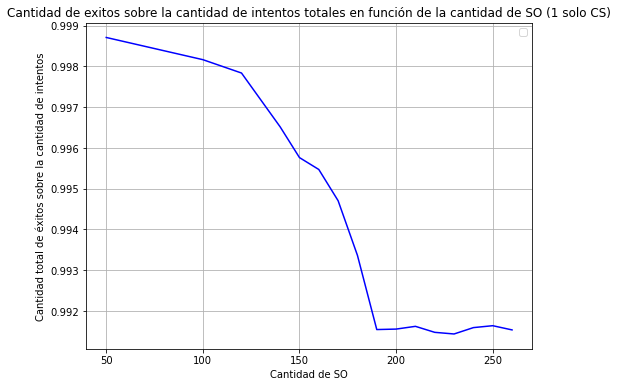

In [7]:
#Gráfica de la cantidad de exitos totales sobre la cantidad de intentos en función de la cantidad de SO.
plt.figure(figsize=(8, 6))
plt.plot(cant_so, valores, 'b')
plt.xlabel('Cantidad de SO')
plt.ylabel('Cantidad total de éxitos sobre la cantidad de intentos')
plt.title('Cantidad de exitos sobre la cantidad de intentos totales en función de la cantidad de SO (1 solo CS)')
plt.legend()
plt.grid(True)
plt.show()

No handles with labels found to put in legend.


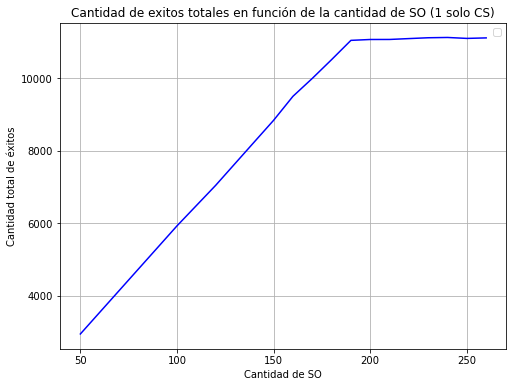

In [8]:
#Gráfica de la cantidad de exitos totales en función de la cantidad de SO con un único CS.
plt.figure(figsize=(8, 6))
cant_tot = []

for c in range(len(cant_so)):
    r_cs, r_so, v, t, intentos, exitos = simulate_ais(num_sotdma=cant_so[c], num_cstdma=1, num_bs=2, num_frames=5, interval_so=5, interval_bs=10, interval_cs=30, frame_length=2250, frame_time=60)
    cant_tot.append(np.sum(exitos))

plt.plot(cant_so, cant_tot, 'b')
plt.xlabel('Cantidad de SO')
plt.ylabel('Cantidad total de éxitos')
plt.title('Cantidad de exitos totales en función de la cantidad de SO (1 solo CS)')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
#Se grafica la cantidad de exitos en funcion de la cantidad de intentos totales (en 5 frames) para una cantidad N de 
#embarcaciones donde hay un porcentaje dado por "num" de embarcaciones de clase CS.

porcentaje = [20, 30, 40, 50, 60, 70, 80]
N = [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400]

eje_y_dict = {}
eje_x_dict = {}

for prop in porcentaje:
    for num in N:
        cant_CS = int(np.round((num*prop)/100))
        cant_SO = num - cant_CS
        r_cs, r_so, v, t, intentos, exitos = simulate_ais(num_sotdma=cant_SO, num_cstdma=cant_CS, num_bs=2, num_frames=5, interval_so=5, interval_bs=10, interval_cs=30, frame_length=2250, frame_time=60)
        
        list_name = f"{int(float(prop))}%_CS"
        
        if list_name not in eje_y_dict:
            eje_y_dict[list_name] = []
        if list_name not in eje_x_dict:
            eje_x_dict[list_name] = []
            
        eje_y_dict[list_name].append(np.sum(exitos))
        eje_x_dict[list_name].append(np.sum(intentos))

In [10]:
eje_y_dict

{'20%_CS': [4916.0,
  5404.0,
  5919.0,
  6400.0,
  6908.0,
  7322.0,
  7832.0,
  8338.0,
  8764.0,
  9174.0,
  9644.0,
  10101.0,
  10507.0,
  10879.0,
  11093.0,
  11071.0,
  11097.0,
  11129.0,
  11101.0,
  11134.0,
  11139.0,
  11140.0,
  11130.0,
  11155.0,
  11172.0,
  11162.0,
  11155.0,
  11193.0,
  11151.0,
  11182.0,
  11188.0],
 '30%_CS': [4418.0,
  4905.0,
  5359.0,
  5773.0,
  6171.0,
  6622.0,
  7056.0,
  7426.0,
  7874.0,
  8361.0,
  8680.0,
  9166.0,
  9503.0,
  9810.0,
  10190.0,
  10536.0,
  10829.0,
  11078.0,
  11090.0,
  11100.0,
  11115.0,
  11122.0,
  11144.0,
  11132.0,
  11147.0,
  11174.0,
  11140.0,
  11172.0,
  11175.0,
  11168.0,
  11170.0],
 '40%_CS': [3912.0,
  4356.0,
  4751.0,
  5042.0,
  5443.0,
  5888.0,
  6190.0,
  6641.0,
  7035.0,
  7384.0,
  7696.0,
  8064.0,
  8392.0,
  8742.0,
  9062.0,
  9413.0,
  9725.0,
  10004.0,
  10255.0,
  10542.0,
  10779.0,
  10993.0,
  11112.0,
  11115.0,
  11122.0,
  11117.0,
  11131.0,
  11149.0,
  11156.0,
  11164.0

In [11]:
eje_x_dict

{'20%_CS': [5068.0,
  5581.0,
  6204.0,
  6707.0,
  7377.0,
  7813.0,
  8520.0,
  9125.0,
  9778.0,
  10582.0,
  11450.0,
  12446.0,
  13328.0,
  14709.0,
  15627.0,
  15725.0,
  16008.0,
  16257.0,
  16405.0,
  16592.0,
  16826.0,
  17043.0,
  17224.0,
  17419.0,
  17611.0,
  17889.0,
  18005.0,
  18280.0,
  18476.0,
  18639.0,
  18872.0],
 '30%_CS': [4625.0,
  5133.0,
  5687.0,
  6124.0,
  6581.0,
  7212.0,
  7754.0,
  8376.0,
  9018.0,
  9819.0,
  10253.0,
  11261.0,
  12208.0,
  12974.0,
  14332.0,
  15428.0,
  17007.0,
  18504.0,
  18941.0,
  19280.0,
  19604.0,
  19915.0,
  20208.0,
  20468.0,
  20914.0,
  21221.0,
  21424.0,
  21787.0,
  22074.0,
  22371.0,
  22718.0],
 '40%_CS': [4079.0,
  4613.0,
  5087.0,
  5453.0,
  5948.0,
  6402.0,
  6940.0,
  7536.0,
  8064.0,
  8628.0,
  9193.0,
  9775.0,
  10398.0,
  11179.0,
  12181.0,
  12939.0,
  14154.0,
  15164.0,
  16450.0,
  18115.0,
  19748.0,
  21839.0,
  23124.0,
  23578.0,
  23943.0,
  24296.0,
  24769.0,
  25304.0,
  25525.0

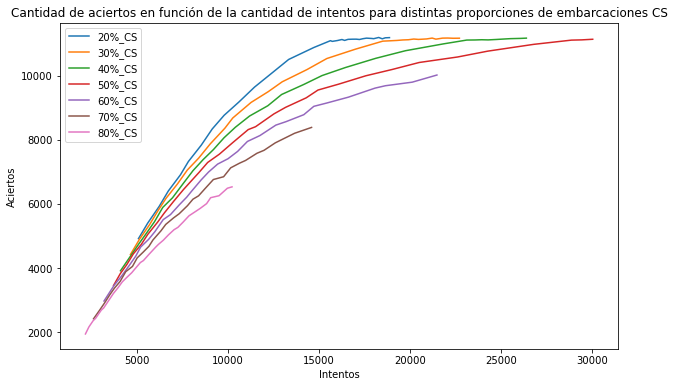

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

for list_name, values_y in eje_y_dict.items():
    values_x = eje_x_dict.get(list_name, [])
    ax.plot(values_x, values_y, label=list_name)

ax.set_xlabel('Intentos')
ax.set_ylabel('Aciertos')
ax.set_title('Cantidad de aciertos en función de la cantidad de intentos para distintas proporciones de embarcaciones CS')

ax.legend()

plt.show()